<a href="https://colab.research.google.com/github/DoutT/Data-Science/blob/master/notebooks/Sorting_Hat_Segmenta%C3%A7%C3%A3o_RFV_regra_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import pydata_google_auth.cache

SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform',
    'https://www.googleapis.com/auth/drive',
]

credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
)

In [73]:
!pip install squarify

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta, date
import os
import sys
import logging
from google.oauth2 import service_account
from google.cloud import bigquery
from oauth2client.service_account import ServiceAccountCredentials
import matplotlib.pyplot as plt
import squarify

os.environ["NLS_LANG"] = "Portuguese_Brazil.UTF8"
logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

In [83]:
ecommerceSalesQuery = """
WITH sales_base as (

SELECT
    id,
    creationDate,
    total,
    statusCode,
    userId,
    1 as isWeb,
    CASE WHEN deliveryType = 'pickup' then 1 else 0 end as isPickup
  FROM `projetoomni.ecommerce_postgres.orders`
  WHERE statusCode BETWEEN 300 AND 320
  AND creationDate >= '2018-01-01'
  
UNION ALL

SELECT
  id,
  DATETIME(createdAt),
  total,
  320,
  userId,
  0,
  0
FROM `projetoomni.pix_read_replica.order`
  WHERE deletedAt is null
  AND createdAt >= '2018-01-01'
)
 
SELECT
  site,
  userId,
  email,
  DATE_DIFF(CURRENT_DATE(), DATE(users.createdAt), DAY) as user_age,
  users.gender,
  DATE_DIFF(CURRENT_DATE(), DATE(max(creationDate)), DAY) as recency,
  count(creationDate) as frequency,
  avg(total) / 100 as monetary,
  CASE WHEN sum(isWeb) = count(o.id) AND sum(ispickup) < 1 THEN 'on'
       WHEN sum(isWeb) < 1 THEN 'off'
       ELSE 'omni' END as segment,
  case when users.cpf is not null then 'cpf'
       when users.cnpj is not null then 'cnpj' end as registro
FROM sales_base o
INNER JOIN `projetoomni.ecommerce_postgres.users` users
ON o.userId = users.id
WHERE site not in ('doramo', 'default')
GROUP BY userId, user_age, gender, site, cpf, cnpj, email
""" 

In [81]:
# Load sales data
dfEcommerceSalesData = pd.read_gbq(ecommerceSalesQuery, project_id="projetoomni", credentials=credentials, dialect = "standard")

Requesting query... 
Requesting query... 
Query running...
Query running...
Job ID: c4109c45-db79-48e0-ae96-b7a6346b0236
Job ID: c4109c45-db79-48e0-ae96-b7a6346b0236
  Elapsed 6.79 s. Waiting...
  Elapsed 6.79 s. Waiting...
  Elapsed 7.88 s. Waiting...
  Elapsed 7.88 s. Waiting...
  Elapsed 8.95 s. Waiting...
  Elapsed 8.95 s. Waiting...
  Elapsed 10.01 s. Waiting...
  Elapsed 10.01 s. Waiting...
  Elapsed 11.09 s. Waiting...
  Elapsed 11.09 s. Waiting...
Query done.
Processed: 776.7 MB Billed: 777.0 MB
Query done.
Processed: 776.7 MB Billed: 777.0 MB
Standard price: $0.00 USD

Standard price: $0.00 USD

Got 1604118 rows.

Got 1604118 rows.

Total time taken 138.95 s.
Finished at 2020-12-14 18:01:26.
Total time taken 138.95 s.
Finished at 2020-12-14 18:01:26.


In [85]:
dfEcommerceSalesData.head()

,site,userId,email,user_age,gender,recency,frequency,monetary,segment,registro
0,artex,8932ecbc-f70c-49fd-af76-7e8a403f5b07,joisejuan@gmail.com,304,F,303,1,209.7,off,cpf
1,artex,b20896e8-95ca-4c43-a8a9-5c2e0cf92e0b,mesiasgilmar@hotmail.com,901,M,308,1,79.9,off,cpf
2,artex,107aa158-50ef-46ed-a678-c5cb4f45e35b,None,902,F,305,2,779.0,off,cpf
3,artex,6b0060be-6030-49b8-a05b-6705ce1b5c78,None,306,None,306,1,134.8,off,cpf
4,artex,74cf726e-7276-48e6-8b87-329541f95485,kellybalthazar@bol.com.br,456,None,30,2,379.7,omni,cpf


In [86]:
data_process = dfEcommerceSalesData.copy() #.dropna()
data_process['monetary'] = np.log1p(data_process['monetary'])

In [106]:
def getRFV(x):
  # Create labels for Recency and Frequency
  r_labels = range(1, 4)
  f_labels = range(3, 0, -1)
  m_labels = range(3, 0, -1)
  a_labels = range(5, 0, -1)

  # Assign these labels to 5 equal percentile groups 
  r_groups = pd.qcut(x['recency'].rank(method='first'),q=3, labels=r_labels).astype('int64')

  # Assign these labels to 3 equal percentile groups 
  f_groups = x['frequency'].apply(lambda x: 1 if x >= 12 else
                                  (3 if x < 6 else 2))
  # Assign these labels to 5 equal percentile groups 
  m_groups = pd.qcut(x['monetary'].rank(method='first'), q=3, labels=m_labels).astype('int64')

  data_process = x.assign(R = r_groups.values,
                          F = f_groups.values,
                          V = m_groups.values)
  
  data_process['score'] = data_process['R'] + data_process['F'] + data_process['V']

  data_process['RFV'] = data_process['score'].apply(lambda x: 'A' if x <= 3 else
                                                    ('C' if x >= 6 else 'B'))

  return data_process

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


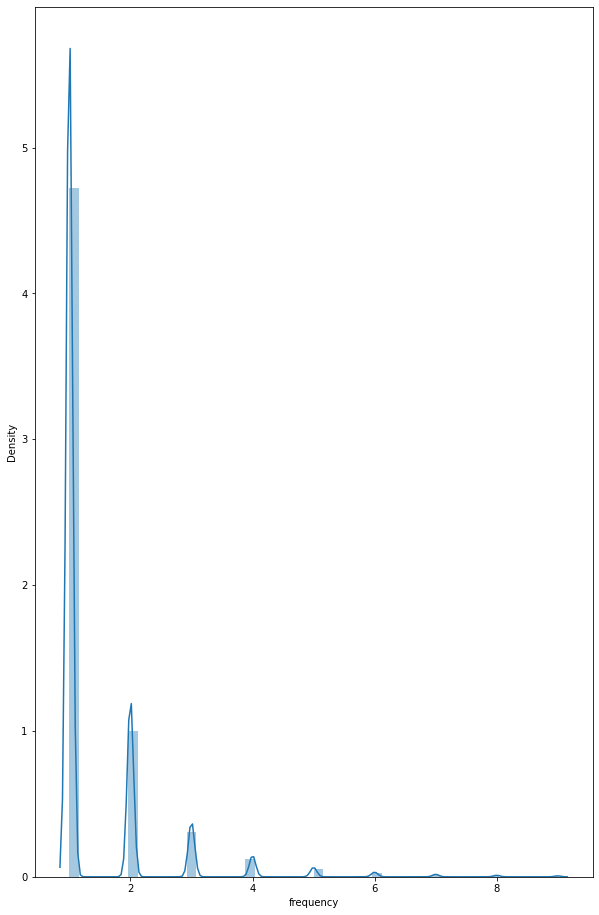

In [104]:
# df_temp = data_process[data_process['frequency'] < 10]
# plt.figure(figsize=(10,16))
# sns.distplot(df_temp['frequency'])

In [107]:
def listaFiltro(primeiro, segundo, terceiro):
       return data_process.loc[data_process['site'] == primeiro].loc[data_process['segment'] == segundo].loc[data_process['registro'] == terceiro]

In [108]:
df_ar_on_cpf = listaFiltro('artex', 'on', 'cpf')
df_ar_off_cpf = listaFiltro('artex', 'off', 'cpf')
df_ar_omni_cpf = listaFiltro('artex', 'omni', 'cpf')

df_ar_on_cnpj = listaFiltro('artex', 'off', 'cnpj')
df_ar_off_cnpj = listaFiltro('artex', 'off', 'cnpj')
df_ar_omni_cnpj = listaFiltro('artex', 'off', 'cnpj')

df_ma_on_cpf = listaFiltro('mmartan', 'on', 'cpf')
df_ma_off_cpf = listaFiltro('mmartan', 'off', 'cpf')
df_ma_omni_cpf = listaFiltro('mmartan', 'omni', 'cpf')

df_ma_on_cnpj = listaFiltro('mmartan', 'on', 'cnpj')
df_ma_off_cnpj = listaFiltro('mmartan', 'off', 'cnpj')
df_ma_omni_cnpj = listaFiltro('mmartan', 'omni', 'cnpj')

df_sa_on_cpf = listaFiltro('santista', 'on', 'cpf')
df_sa_off_cpf = listaFiltro('santista', 'off', 'cpf')
df_sa_omni_cpf = listaFiltro('santista', 'omni', 'cpf')

df_sa_on_cnpj = listaFiltro('santista', 'on', 'cnpj')
df_sa_off_cnpj = listaFiltro('santista', 'off', 'cnpj')
df_sa_omni_cnpj = listaFiltro('santista', 'omni', 'cnpj')



In [109]:
df_ar_on_cpf = getRFV(df_ar_on_cpf)
df_ar_off_cpf = getRFV(df_ar_off_cpf)
df_ar_omni_cpf = getRFV(df_ar_omni_cpf)

df_ar_on_cnpj = getRFV(df_ar_on_cnpj)
df_ar_off_cnpj = getRFV(df_ar_off_cnpj)
df_ar_omni_cnpj = getRFV(df_ar_omni_cnpj)

df_ma_on_cpf = getRFV(df_ma_on_cpf)
df_ma_off_cpf = getRFV(df_ma_off_cpf)
df_ma_omni_cpf = getRFV(df_ma_omni_cpf)

df_ma_on_cnpj = getRFV(df_ma_on_cnpj)
df_ma_off_cnpj = getRFV(df_ma_off_cnpj)
df_ma_omni_cnpj = getRFV(df_ma_omni_cnpj)

df_sa_on_cpf = getRFV(df_sa_on_cpf)
# df_sa_off_cpf = getRFV(df_sa_off_cpf)
# df_sa_omni_cpf = getRFV(df_sa_omni_cpf)

df_sa_on_cnpj = getRFV(df_sa_on_cnpj)
# df_sa_off_cnpj = getRFV(df_sa_off_cnpj)
# df_sa_omni_cnpj = getRFV(df_sa_omni_cnpj)


In [110]:
df_ar_off_cpf.head()

,site,userId,email,user_age,gender,recency,frequency,monetary,segment,registro,R,F,V,score,RFV
0,artex,8932ecbc-f70c-49fd-af76-7e8a403f5b07,joisejuan@gmail.com,304,F,303,1,5.350435,off,cpf,2,3,2,7,C
1,artex,b20896e8-95ca-4c43-a8a9-5c2e0cf92e0b,mesiasgilmar@hotmail.com,901,M,308,1,4.393214,off,cpf,2,3,3,8,C
2,artex,107aa158-50ef-46ed-a678-c5cb4f45e35b,None,902,F,305,2,6.659294,off,cpf,2,3,1,6,C
3,artex,6b0060be-6030-49b8-a05b-6705ce1b5c78,None,306,None,306,1,4.911183,off,cpf,2,3,3,8,C
5,artex,68bdb38a-d924-430b-969f-d09d5dae80c4,antoniopereirasilva25@hotmail.com,299,F,299,1,6.041444,off,cpf,2,3,1,6,C


In [122]:
df_results_artex = pd.concat([df_ar_on_cpf,
                              df_ar_omni_cpf,
                              df_ar_off_cpf,
                              df_ar_on_cnpj,
                              df_ar_off_cnpj,
                              df_ar_omni_cnpj]
                             ,ignore_index=True).sort_values(by=['RFV']).reset_index().drop(columns=['index'])


df_results_mmartan = pd.concat([df_ma_on_cpf,
                              df_ma_off_cpf,
                              df_ma_omni_cpf,
                              df_ma_on_cnpj,
                              df_ma_off_cnpj,
                              df_ma_omni_cnpj]
                             ,ignore_index=True).sort_values(by=['RFV']).reset_index().drop(columns=['index']) 


df_results_santista = pd.concat([df_sa_on_cpf,
                                df_sa_on_cnpj]
                               ,ignore_index=True).sort_values(by=['RFV']).reset_index().drop(columns=['index']) 



In [123]:
df_results_artex.head()

,site,userId,email,user_age,gender,recency,frequency,monetary,segment,registro,R,F,V,score,RFV
0,artex,2f0116a8-9c0f-4531-8082-f515f8713002,anacmcampos@msn.com,461,None,26,14,8.059614,omni,cpf,1,1,1,3,A
1,artex,4a2edcdd-2300-47fa-bb68-adcb5d8479ec,fatimamarinheiro@yahoo.com.br,881,F,64,20,8.080566,omni,cpf,1,1,1,3,A
2,artex,ef366370-f3b4-4101-9acb-47316fb7dfbd,gkellyvanessa2016@gmail.com,404,F,18,21,7.459828,off,cpf,1,1,1,3,A
3,artex,9e61eca0-cfb0-4612-a3bc-4e50b46876c0,angelamamelo@yahoo.com.br,932,None,55,23,8.763916,on,cpf,1,1,1,3,A
4,artex,d344c91f-a11c-4fad-8376-bec9b4e37ab0,anaantonelli@bol.com.br,1046,F,51,27,8.926128,omni,cpf,1,1,1,3,A


In [117]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [124]:
# df_results.to_xlsx(r'./drive/My Drive/Colab Notebooks/estudo_rfv_2.xlsx', sheet_name='estudo_rfv_2', index = False)
df_results_artex.to_csv(r'./drive/My Drive/Colab Notebooks/Estudo RFV/estudo_artex_rfv_2.csv',index=False)
df_results_mmartan.to_csv(r'./drive/My Drive/Colab Notebooks/Estudo RFV/estudo_mmartan_rfv_2.csv',index=False)
df_results_santista.to_csv(r'./drive/My Drive/Colab Notebooks/Estudo RFV/estudo_santista_rfv_2.csv',index=False)